In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


label is 1


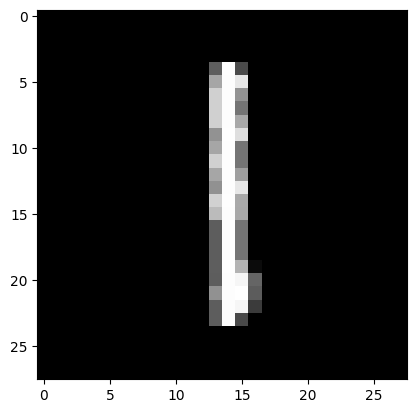

In [3]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [4]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#question 4

print(f"Numeber of optimization variables: {model.count_params()}")

Numeber of optimization variables: 26506


In [6]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([9, 9, 2, 5, 8, 8, 9, 9, 8, 9, 9, 4, 9, 8, 3, 5, 8, 9, 5, 9, 9, 3,
       9, 5, 3, 9, 7, 9, 8, 3])

In [7]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [8]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [9]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [10]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3482049

# 4. Training the model

In [11]:
# Algorithme SGD sans mini-batching
def SGD_without_minibatch(model, x_train, y_train, learning_rate, epochs=1, log_interval=2000):
    # Liste pour stocker les pertes et les itérations associées
    loss_history = []
    iterations = []

    # Vérification des NaN dans les données
    if np.isnan(x_train).any() or np.isnan(y_train).any():
        raise ValueError("Les données d'entrée contiennent des valeurs NaN.")

    iteration_count = 0  # Compteur global d'itérations

    for epoch in range(epochs):
        epoch_loss = 0.0  # Cumul de la perte pour l'époque
        num_samples = len(x_train)

        for i in range(num_samples//2):
            x_sample = x_train[i:i+1]  # Un seul échantillon
            y_sample = y_train[i:i+1]  # Étiquette correspondante

            with tf.GradientTape() as tape:
                logits = model(x_sample)  # Prédictions pour un échantillon
                # Calcul de la perte pour l'échantillon actuel
                loss_value = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_sample, logits)
                )

            # Vérification que la perte est valide
            if tf.math.is_nan(loss_value):
                raise ValueError("La perte est NaN. Vérifiez vos données ou votre modèle.")

            # Calcul des gradients
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Mise à jour des poids du modèle
            update_weights(model, grads, real_factor=-learning_rate)

            # Accumulation de la perte pour l'époque
            epoch_loss += loss_value.numpy()

            # Calcul de la perte toutes les `log_interval` itérations
            if iteration_count % log_interval == 0:
                total_loss = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_train, model(x_train))
                ).numpy()
                loss_history.append(total_loss)
                iterations.append(iteration_count)
                print(f"Iteration {iteration_count}, Loss: {total_loss:.4f}")

            iteration_count += 1

        # Affichage de la perte moyenne à la fin de l'époque
        average_epoch_loss = epoch_loss / num_samples
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_epoch_loss:.4f}")

    # Retourner l'historique des pertes et les itérations correspondantes
    return iterations, loss_history

In [12]:
print(len(x_train))

60000


In [13]:
# initialize model
model = build_model()
# Entraînement du model
iterations,loss_history =SGD_without_minibatch(model, x_train, y_train, learning_rate=0.01, epochs=1)

Iteration 0, Loss: 2.3287
Iteration 2000, Loss: 0.7219
Iteration 4000, Loss: 0.3956
Iteration 6000, Loss: 0.4077
Iteration 8000, Loss: 0.4488
Iteration 10000, Loss: 0.3177
Iteration 12000, Loss: 0.3137
Iteration 14000, Loss: 0.3131
Iteration 16000, Loss: 0.2589
Iteration 18000, Loss: 0.2412
Iteration 20000, Loss: 0.2345
Iteration 22000, Loss: 0.2916
Iteration 24000, Loss: 0.2377
Iteration 26000, Loss: 0.2394
Iteration 28000, Loss: 0.2147
Epoch 1/1, Average Loss: 0.1694


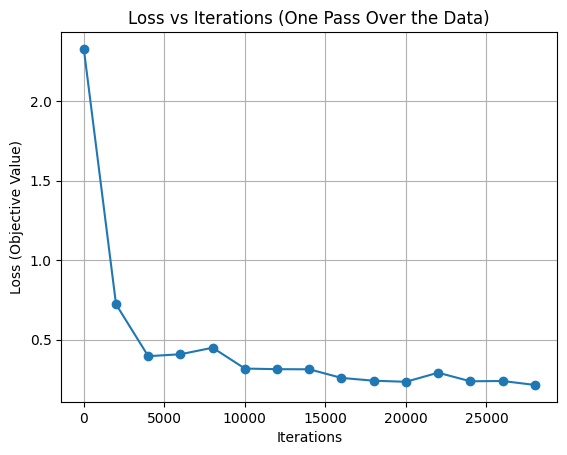

In [14]:
#Q5.2
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

Des learning rates plus élevés (0.1 et 0.01) permettent une convergence plus rapide de la perte par rapport à un learning rate plus faible (0.001).

  -Avec un learning rate de 0.1, la perte diminue très rapidement, atteignant une valeur inférieure à 0.2 dès les premières itérations, ce qui indique une convergence efficace.            
  -Le learning rate de 0.01 affiche également une bonne descente de la perte, bien qu'un peu plus lente que 0.10.1, atteignant environ 0.4 après 1500 itérations.        
  -En revanche, le learning rate de 0.001 montre une convergence très lente, avec une perte qui reste élevée (~1.8), illustrant un sous-apprentissage après le même nombre d'itérations.

Cela démontre que le choix du learning rate est crucial : un taux trop petit ralentit l'apprentissage, tandis qu'un taux modéré (comme 0.1 ici) permet d'apprendre rapidement sans instabilité apparente. 🚀

In [15]:
model = build_model()
# Entraînement sur 5 epochs
iterations, loss_history = SGD_without_minibatch(model, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3704
Iteration 2000, Loss: 0.5741
Iteration 4000, Loss: 0.4424
Iteration 6000, Loss: 0.4175
Iteration 8000, Loss: 0.3751
Iteration 10000, Loss: 0.3348
Iteration 12000, Loss: 0.2976
Iteration 14000, Loss: 0.2945
Iteration 16000, Loss: 0.2654
Iteration 18000, Loss: 0.2379
Iteration 20000, Loss: 0.2753
Iteration 22000, Loss: 0.2781
Iteration 24000, Loss: 0.2220
Iteration 26000, Loss: 0.2212
Iteration 28000, Loss: 0.2344
Epoch 1/5, Average Loss: 0.1696
Iteration 30000, Loss: 0.2242
Iteration 32000, Loss: 0.1998
Iteration 34000, Loss: 0.1924
Iteration 36000, Loss: 0.1983
Iteration 38000, Loss: 0.2253
Iteration 40000, Loss: 0.2101
Iteration 42000, Loss: 0.1895
Iteration 44000, Loss: 0.1793
Iteration 46000, Loss: 0.1762
Iteration 48000, Loss: 0.1822
Iteration 50000, Loss: 0.2185
Iteration 52000, Loss: 0.2328
Iteration 54000, Loss: 0.2027
Iteration 56000, Loss: 0.1810
Iteration 58000, Loss: 0.1721
Epoch 2/5, Average Loss: 0.0910
Iteration 60000, Loss: 0.1733
Iteration 6200

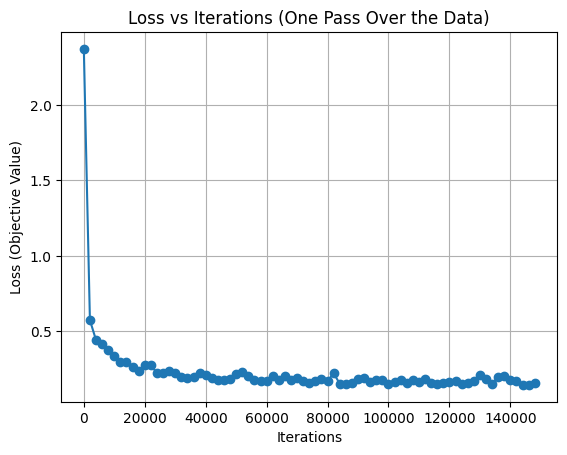

In [16]:
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

each epoch allows the model to adjust its weights based on previous errors, gradually improving its performance.

 After multiple epochs, the model has more opportunities to learn complex patterns in the data, leading to a reduction in loss.
 This decrease indicates that the model is converging effectively toward a minimum of the loss function.

In [17]:
#QUESTION 6
# Stochastic gradient algorithm with mini batching

def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=32, log_interval=2000):
    # Liste pour stocker les pertes et les itérations associées
    loss_history = []
    iterations = []

    # Vérification des NaN dans les données
    if np.isnan(x_train).any() or np.isnan(y_train).any():
        raise ValueError("Les données d'entrée contiennent des valeurs NaN.")

    iteration_count = 0  # Compteur global d'itérations

    for epoch in range(epochs):
        epoch_loss = 0.0  # Cumul de la perte pour l'époque
        num_batches = int(np.ceil(len(x_train) / batch_size))

        for batch_start in range(0, len(x_train), batch_size):
            batch_end = batch_start + batch_size
            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            with tf.GradientTape() as tape:
                logits = model(x_batch)  # Prédictions
                # Calcul de la perte pour le batch actuel
                loss_value = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits)
                )

            # Vérification que la perte est valide
            if tf.math.is_nan(loss_value):
                raise ValueError("La perte est NaN. Vérifiez vos données ou votre modèle.")

            # Calcul des gradients
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Mise à jour des poids du modèle
            update_weights(model, grads, real_factor=-learning_rate)

            # Accumulation de la perte pour l'époque
            epoch_loss += loss_value.numpy()

            # Calcul de la perte toutes les `log_interval` itérations
            if iteration_count % log_interval == 0:
                total_loss = tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_train, model(x_train))
                ).numpy()
                loss_history.append(total_loss)
                iterations.append(iteration_count)
                print(f"Iteration {iteration_count}, Loss: {total_loss:.4f}")

            iteration_count += 1

        # Affichage de la perte moyenne à la fin de l'époque
        average_epoch_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_epoch_loss:.4f}")

    # Retourner l'historique des pertes et les itérations correspondantes
    return iterations, loss_history





In [18]:
model = build_model()
# Entraînement sur 5 epochs
iterations, loss_history = SGD(model, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3313
Epoch 1/5, Average Loss: 0.7603
Iteration 2000, Loss: 0.3643
Epoch 2/5, Average Loss: 0.3313
Iteration 4000, Loss: 0.3063
Epoch 3/5, Average Loss: 0.2803
Iteration 6000, Loss: 0.2621
Epoch 4/5, Average Loss: 0.2485
Iteration 8000, Loss: 0.2272
Epoch 5/5, Average Loss: 0.2246



Minibatching provides a balance between speed and stability by averaging gradients over a small batch, reducing noise compared to pure SGD. It allows for faster convergence with more stable updates

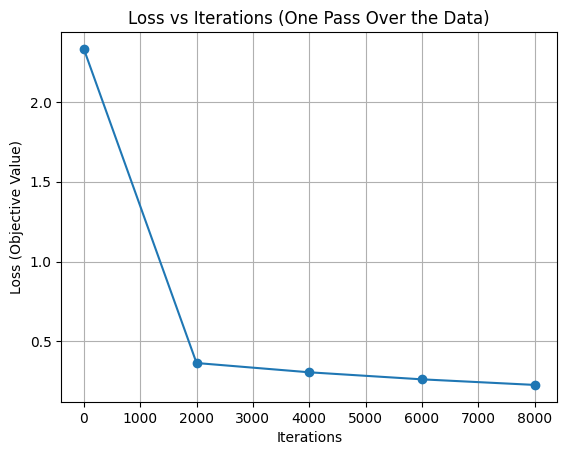

In [19]:
plt.plot(iterations, loss_history, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (Objective Value)")
plt.title("Loss vs Iterations (One Pass Over the Data)")
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import accuracy_score

# Function to evaluate model accuracy
def evaluate_accuracy(model, x_data, y_data):
    predictions = model.predict(x_data)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_data, predicted_labels)
    return accuracy

In [22]:
# Training with SGD (minibatching)
model_minibatch = build_model()
SGD(model_minibatch, x_train, y_train, learning_rate=0.01, epochs=5, batch_size=32, log_interval=2000)

# Training with SGD (without minibatching)
model_no_minibatch = build_model()
SGD_without_minibatch(model_no_minibatch, x_train, y_train, learning_rate=0.01, epochs=5, log_interval=2000)

Iteration 0, Loss: 2.3640
Epoch 1/5, Average Loss: 0.7363
Iteration 2000, Loss: 0.3560
Epoch 2/5, Average Loss: 0.3216
Iteration 4000, Loss: 0.2969
Epoch 3/5, Average Loss: 0.2714
Iteration 6000, Loss: 0.2572
Epoch 4/5, Average Loss: 0.2411
Iteration 8000, Loss: 0.2214
Epoch 5/5, Average Loss: 0.2189
Iteration 0, Loss: 2.3449
Iteration 2000, Loss: 0.6935
Iteration 4000, Loss: 0.4084
Iteration 6000, Loss: 0.3986
Iteration 8000, Loss: 0.3886
Iteration 10000, Loss: 0.3612
Iteration 12000, Loss: 0.2947
Iteration 14000, Loss: 0.2830
Iteration 16000, Loss: 0.2739
Iteration 18000, Loss: 0.2543
Iteration 20000, Loss: 0.2443
Iteration 22000, Loss: 0.2777
Iteration 24000, Loss: 0.2358
Iteration 26000, Loss: 0.2346
Iteration 28000, Loss: 0.2080
Epoch 1/5, Average Loss: 0.1700
Iteration 30000, Loss: 0.2455
Iteration 32000, Loss: 0.2185
Iteration 34000, Loss: 0.2097
Iteration 36000, Loss: 0.2288
Iteration 38000, Loss: 0.2474
Iteration 40000, Loss: 0.2062
Iteration 42000, Loss: 0.2622
Iteration 4400

([0,
  2000,
  4000,
  6000,
  8000,
  10000,
  12000,
  14000,
  16000,
  18000,
  20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  34000,
  36000,
  38000,
  40000,
  42000,
  44000,
  46000,
  48000,
  50000,
  52000,
  54000,
  56000,
  58000,
  60000,
  62000,
  64000,
  66000,
  68000,
  70000,
  72000,
  74000,
  76000,
  78000,
  80000,
  82000,
  84000,
  86000,
  88000,
  90000,
  92000,
  94000,
  96000,
  98000,
  100000,
  102000,
  104000,
  106000,
  108000,
  110000,
  112000,
  114000,
  116000,
  118000,
  120000,
  122000,
  124000,
  126000,
  128000,
  130000,
  132000,
  134000,
  136000,
  138000,
  140000,
  142000,
  144000,
  146000,
  148000],
 [2.3448808,
  0.6934901,
  0.4084002,
  0.3986256,
  0.38857168,
  0.3612021,
  0.29468232,
  0.28298622,
  0.27391022,
  0.25431576,
  0.24430117,
  0.277663,
  0.23579462,
  0.23459896,
  0.20803131,
  0.24547876,
  0.21848686,
  0.20968905,
  0.2287569,
  0.24738212,
  0.2061881,
  0.26223832,
  0.1853

In [23]:
# Evaluate accuracy
train_acc_minibatch = evaluate_accuracy(model_minibatch, x_train, y_train)


train_acc_no_minibatch = evaluate_accuracy(model_no_minibatch, x_train, y_train)


# Display results
print(f"Minibatch SGD - Training Accuracy: {train_acc_minibatch:.4f} ")
print(f"SGD without Minibatch - Training Accuracy: {train_acc_no_minibatch:.4f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Minibatch SGD - Training Accuracy: 0.9383 
SGD without Minibatch - Training Accuracy: 0.9558


# 📊 Model Accuracy Evaluation: Training vs Test Set

## 1. **Training Accuracy**
Models trained with **SGD using minibatching** often achieve **slightly lower training accuracy** compared to models trained without minibatching. This is because minibatching introduces a **regularizing effect**, preventing the model from overfitting to the training data.  
In contrast, **SGD without minibatching** (batch size = 1) tends to achieve **higher training accuracy** because it aggressively updates the model based on each individual data point, which can lead to **overfitting**.

## 2. **Test Accuracy (Generalization)**
Despite potentially lower training accuracy, models trained with **minibatching** usually show **better generalization performance** on the test set. The smoother gradient updates help the model avoid sharp minima, making it more robust to new, unseen data.  
On the other hand, **SGD without minibatching** might perform worse on the test set due to **overfitting**, as it has adapted too closely to the specific patterns (or even noise) in the training data.

## 3. **Convergence and Stability**
- **Minibatch SGD:** Provides **more stable convergence**, with smoother accuracy improvements over epochs.  
- **Pure SGD (without minibatching):** Can lead to **fluctuations in accuracy** due to the high variance in gradient estimates, making convergence less stable.

## 4. **Impact of Batch Size**
Increasing the batch size generally improves test accuracy up to a certain point. However, if the batch size is **too large**, the model may **converge too quickly to sharp minima**, reducing generalization performance. A **moderate batch size** often provides the best trade-off between **stability** and **generalization**.
